In [1]:
import os
import pandas as pd
import json
import numpy as np
from tabulate import tabulate
from collections import OrderedDict
import seaborn as sns
from numbers import Number
from functools import reduce
from operator import and_

%matplotlib inline

In [2]:
DF_PATH = os.path.join("data", "clean", "anes.tsv")
CODEBOOK_PATH = os.path.join("data", "clean", "anes_cb.json")

In [3]:
from IPython.display import Markdown


def header_pair(line, char="="):
    return [line, char * len(line)]


def var_def_to_md_str(cb, name, include_notes=True):
    var_def = cb['var_defs'].get(name)
    if not var_def:
        return 'Not Found'
    
    lines = header_pair(name)

    module = var_def.get('module')
    if module:
        lines.extend(header_pair(module, "-"))

    desc = var_def.get('desc', [])
    if module:
        lines.append(desc)

    prompt = var_def.get('prompt')
    if prompt:
        lines.extend(header_pair('Prompt', "-"))
        lines.extend(prompt)

    if 'codes' in var_def:
        lines.extend(header_pair('Codes', "-"))

    for k, codes in var_def.get('codes', {}).items():
        if k != 'UNIFORM':
            lines.extend(header_pair(k, "~"))
        tbl = sorted(list(codes['codes'].items()))
        s = tabulate(tbl, headers=['Code', 'Desc'], tablefmt='pipe')
        lines.append(s)


    notes = var_def.get('notes')
    if notes and include_notes:
        lines.extend(header_pair('Notes', "-"))
        lines.extend(prompt)

    return "\n".join(lines)


def var_names_matching(cb, q):
    q = q.lower()
    
    matches = set()
    for k, v in cb['var_defs'].items():
        
        if q in v.get('desc', '').lower():
            matches.add(k)
            
        if q in v.get('module', '').lower():
            matches.add(k)
    
    return matches


def collect_missing_codes(cb, var_name):
    missing_values = {-100}
    
    for k, coding in cb['var_defs'][var_name].get('codes', {}).items():
        for v in coding.get('missing', []):
            if v != 'INAP':
                missing_values.add(int(v))
                
    return missing_values


def remove_missings(df, cb, var_name):
    x = df[var_name]
    missing_values = collect_missing_codes(cb, var_name)
    return x[~np.in1d(x, list(missing_values))]


class ANES:
    def __init__(self, tsv_path, cb_path):
        with open(cb_path) as fp:
            self.cb = json.load(fp, object_hook=OrderedDict)
            
        self.df = pd.read_csv(tsv_path, sep="\t")
        
    def describe(self, var_name, include_notes=True):
        return Markdown(var_def_to_md_str(self.cb, var_name, include_notes))
    
    def plot_counts(self, var_name, ignore_missing=False):
        if var_name not in self.df.columns:
            return 'not found'

        sns.set_style('white')
        
        if ignore_missing:
            x = remove_missings(self.df, self.cb, var_name)
        else:
            x = self.df[var_name]

        counts = x.value_counts()
        title = "{} Counts".format(var_name)
        counts.sort_index(ascending=False).plot(kind='barh', title=title)
        sns.despine()
        
    def search_for(self, q):
        matches = var_names_matching(self.cb, q)
        if not matches:
            return "Not found"

        var_defs = self.cb['var_defs']
        serps = []
        for k in sorted(matches):
            var_def = var_defs[k]
            serps.append([k, 
                          var_def.get('module', ''),
                          var_def.get('desc', ''),
                          " ".join(var_def.get('prompt'))])

        s = tabulate(serps, headers=['Name', 'Module', 'Desc', 'Prompt'], tablefmt='pipe')
        return Markdown(s)
    
    def select(self, k, *other_ks, years=None, strip_missings=False):
        ks = []

        if years is not None:
            ks.append('VCF0004')
            if isinstance(years, Number):
                years = [years]

        ks.append(k)
        ks.extend(list(other_ks))

        sub_df = self.df[ks].copy()

        if years is not None:
            idx = np.in1d(sub_df['VCF0004'], years)
            sub_df = sub_df[idx]

        if strip_missings:
            conds = []

            for k in sub_df.columns:
                missing_values = collect_missing_codes(self.cb, k)
                x = sub_df[k]
                conds.append(~np.in1d(x, list(missing_values)))

            sub_df = sub_df[reduce(and_, conds)]

        return sub_df
    
    
anes = ANES(DF_PATH, CODEBOOK_PATH)

/Users/generativist/anaconda/envs/odin/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (112,113,642) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [4]:
anes.describe('VERSION2')

Not Found

In [5]:
anes.describe('VERSION')

VERSION
=======
STUDY VARIABLE
--------------
Version Number Of Release
Prompt
------
Version of Cumulative Data File
Notes
-----
Version of Cumulative Data File

In [6]:
anes.describe('VCF0127A')

VCF0127A
========
DEMOGRAPHICS
------------
Household - Who Belongs to Union 8-category
Prompt
------
(1988-LATER EXC.2002: Do you or [1988: does] anyone else; 2002: Does
anyone) in this household belong to a labor union?
(IF YES:)  Who is it that belongs?
Codes
-----
| Code   | Desc                                                                    |
|:-------|:------------------------------------------------------------------------|
| 00     | No one                                                                  |
| 11     | Respondent only                                                         |
| 12     | Spouse only                                                             |
| 13     | Other household member only                                             |
| 21     | R and spouse                                                            |
| 22     | R and other household member                                            |
| 23     | Spouse and other household member                                       |
| 31     | R, spouse and other household member                                    |
| 99     | DK; NA; DK/NA if anyone in union; short-form 'new' Cross Section (1992) |
| INAP   | Inap. question not used                                                 |
Notes
-----
(1988-LATER EXC.2002: Do you or [1988: does] anyone else; 2002: Does
anyone) in this household belong to a labor union?
(IF YES:)  Who is it that belongs?

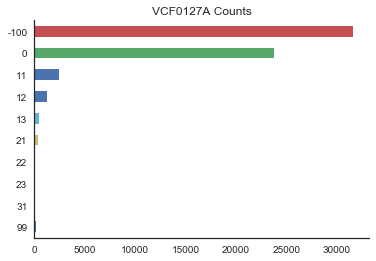

In [7]:
anes.plot_counts('VCF0127A')

In [8]:
anes.search_for('year')

| Name     | Module                  | Desc                                                         | Prompt                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
|:---------|:------------------------|:-------------------------------------------------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| VCF0004  | STUDY VARIABLE          | Year of Study                                                | Year of study (4-digit)                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
| VCF0006  | STUDY VARIABLE          | Study Respondent Number: Year-level Case ID                  | Case identification number                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| VCF0006A | STUDY VARIABLE          | Unique Respondent Number (Cross-year ID for panel cases)     | Unique identification number                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| VCF0870  | ISSUES                  | Better or Worse Economy in Past Year                         | How about (1996-LATER: Now thinking about) the economy (1990,1994- later: in the country as a whole)? ALL YEARS EXC. 2000 VERSION 2: Would you say that over the past year the nation's economy has gotten better, stayed (all yrs. exc 1984: about) the same or gotten worse? 2000 VERSION 2: Would you say that over the past year the nation's economy has gotten worse, stayed about the same, or gotten better?                                                        |
| VCF0871  | ISSUES                  | How Much Better or Worse Economy in Past Year                | How about (1996-LATER: Now thinking about) the economy (1990,1994- later: in the country as a whole)? Would you say that over the past year the nation's economy has gotten better, stayed (all yrs. exc 1984: about) the same or gotten worse? (IF BETTER:) Would you say much better or somewhat better? (IF WORSE:)  Would you say much worse or somewhat worse?                                                                                                         |
| VCF0872  | ISSUES                  | Better or Worse Economy in Next Year                         | What about the next 12 months (1980,1982: or so)? ALL YEARS EXC. 2000: Do you expect the (1986,1988,1992: national) economy to get better, get worse, or stay about the same? 2000 VERSION 1: Do you expect the economy, in the country as a whole, to get better, stay about the same, or get worse? 2000 VERSION 2: Do you expect the economy, in the country as a whole, to get worse, stay about the same, or get better?                                               |
| VCF0880  | ECONOMIC WELL-BEING     | Better or Worse Off in Past Year                             | 1962-1998,2004: We are interested in how people are getting along financially these days. Would you say that (1962,1966-1974: you [and your family]; 1976 and later : you [and your family living here]) are better off or worse off financially than you were a year ago. 2000-2002: Would you say that you (and your family) (2000 FACE-TO-FACE ONLY: living here) are better off, worse off, or just about the same financially as you were a year ago?                  |
| VCF0880A | ECONOMIC WELL-BEING     | How Much Better/Worse Off in Past Year                       | 1984-1998,2004: We are interested in how people are getting along financially these days. Would you say that you and your family living here are better off or worse off financially than you were a year ago. 2000-2002: Would you say that you (and your family) (2000 FACE-TO-FACE ONLY: living here) are better off, worse off, or just about the same financially as you were a year ago? Is that much better/worse off or somewhat better/worse off?                  |
| VCF0880B | ECONOMIC WELL-BEING     | Financial Situation Better/Worse in Past Few Years           | During the last few years, has your financial situation been getting better, getting worse, or has it stayed the same?                                                                                                                                                                                                                                                                                                                                                      |
| VCF0881  | ECONOMIC WELL-BEING     | Better or Worse Off in Next Year                             | 1956-1960,1964: Now looking ahead and thinking about the next few years, do you expect your financial situation will stay about the way it is now, get better, or get worse. 1962,1966 AND LATER: Now looking ahead--do you think that a year from now (1962,1966-1970: you people; 1972,1974: you [and your family]; 1976 AND LATER: you [and your family; 2000 TELEPHONE,2004: living here]) will be better  off financially or worse off, or just about the same as now? |
| VCF9042  | RACIAL RESENTMENT       | Blacks Gotten Less than They Deserve Over the Past Few Years | 'Over the past few years blacks have gotten less than they deserve.'                                                                                                                                                                                                                                                                                                                                                                                                        |
| VCF9045  | CONDITION/GOALS OF U.S. | Position of the U.S. Weaker/Stronger in the Past Year        | 1958,1960,1964,1968: Would you say that in the past year or so our position in the world has become stronger, less strong, or has it stayed about the same? 1984 AND 1984-LATER: (2002,2004: Turning to some other issues facing the country) During the past year, would you say that the United States' position in the world has grown weaker, stayed about the same, or has it grown stronger?                                                                          |
| VCF9053  | ECONOMIC WELL-BEING     | Income Kept Up with Costs in Last Year                       | Do you think that over the last year your/your family's income has gone up more than the cost of living, has it fallen behind, or has it stayed about even with the cost of living? (IF GONE UP OR FALLEN BEHIND) Has it (gone up/fallen behind) a lot or (gone up/fallen behind) a little?                                                                                                                                                                                 |

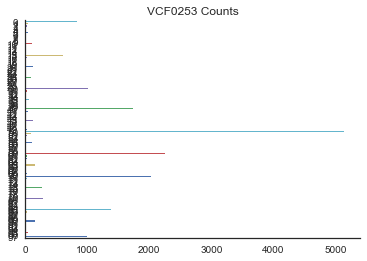

In [9]:
anes.plot_counts('VCF0253', ignore_missing=True)

In [23]:
sub_df = anes.select('VCF0838', 'VCF0837', 
                     years=[1972, 1976, 1978, 1980],
                     strip_missings=True)
x = sub_df.pivot_table('VCF0004', ['VCF0838', 'VCF0837'], aggfunc='count').unstack()
x

VCF0004                   
VCF0837       1    2    3    4   9
VCF0838                           
1            75   73    7    3   1
2            40  334   36   14  12
3             7  120   90   30   3
4             8   57  107  319  11
9             2   23    5    8  10

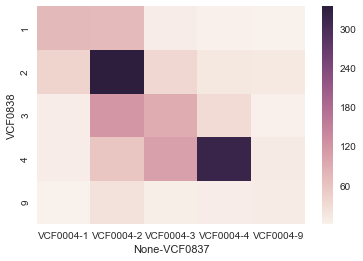

In [25]:
sns.heatmap(x);